# Model Building & Comparison

In [ ]:
#pip install contractions

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import re, string, unicodedata
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
import contractions
from textblob import TextBlob
##import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.tokenize import word_tokenize,RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from zipfile import ZipFile
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import tensorflow as tf
from keras.models import Sequential
from keras import layers
from keras.optimizers import adam_v2
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.layers import Flatten

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1. Data pre-processing

Exact the files from zip, then combine the content into 1 list.

In [ ]:
def unzip(file_name):
  with ZipFile(file_name, 'r') as zip:
    zip.extractall()
    print('Done')

In [ ]:
unzip('Movie_reviews_labeled.zip')
unzip('Critic Reviews labeled.zip')

Done
Done


In [ ]:
path = r'Movie_reviews_labeled' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

Reviews = pd.concat(li, axis=0, ignore_index=True)

In [ ]:
path = r'Critic Reviews labeled' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, lineterminator='\n', index_col=None, header=0)
    li.append(df)

Critics = pd.concat(li, axis=0, ignore_index=True)

**Ordinal encoding the sentiment variables into integer:**

0 -> negative, 1 -> positive

**Text pre-processing:**

We are using NLTK package to clean the text:

  • Lower the text

  • Remove Weblinks

  • Remove Special characters

  • Lemmatization e.g.(sat -> sit)

  • Remove Stopwords


In [ ]:
IMDB = Reviews.iloc[:,2:4]
Metacritics = Critics.iloc[:,6:8]

In [ ]:
def OrdinalEncoding(data):
    ordinal_encoder = OrdinalEncoder()
    target = data["Emotion"]
    target = ordinal_encoder.fit_transform(data["Emotion"].values.reshape(-1,1))
    target = pd.DataFrame(target,columns = ["Emotion"]).reset_index(drop = True)
    text = data.drop(columns = ['Emotion']).reset_index(drop = True)
    data = pd.concat([text, target],axis = 1)
    return data

In [ ]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

def preprocess(Text):
    Text=str(Text)
       
    # Lowering the text
    Text = Text.lower()
    
    # Removing Weblinks
    Text=Text.replace('{html}',"")
    
    # Removing Special characters
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', Text)
    
    #Removing URLs
    rem_url=re.sub(r'http\S+', '',cleantext)
    
    # Removing Numbers
    rem_num = re.sub('[0-9]+', '', rem_url)
    
    # Lemmatization
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    
    # Removing Stopwords.
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    
    return " ".join(filtered_words)

In [ ]:
IMDB = OrdinalEncoding(IMDB)
IMDB['Comment_cleaned']=IMDB['Comment'].map(lambda s:preprocess(s)) 

Metacritics = OrdinalEncoding(Metacritics)
Metacritics['Review_cleaned']=Metacritics['Review'].map(lambda s:preprocess(s)) 

**Word Embeddings: represent words as numeric vector.**

  We use TF-IDF Vectorize, Term Frequency (TF) and Inverse Document Frequency (IDF) are to measure the importance of a word in a document.

In [ ]:
tfidf_converter = TfidfVectorizer(max_features = 2000)
features_imdb = tfidf_converter.fit_transform(IMDB['Comment_cleaned']).toarray()
features_meta = tfidf_converter.fit_transform(Metacritics['Review_cleaned']).toarray()

## 2. Logistic Regression

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

Split the data as 80% training data and 20% test data.

In [ ]:
X = IMDB['Comment_cleaned']
y = IMDB['Emotion']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Bag of Words - IMDB

Word embedding through Bag of Words for Logistic Regression

In [ ]:
bw = CountVectorizer(min_df=0, max_df=1, binary=False, ngram_range=(1,3))

#transformed X training set
bw_train_IMDB = bw.fit_transform(X_train)

#transformed X test set
bw_test_IMDB = bw.transform(X_test)

Fitting and training the model

In [ ]:
lr = LogisticRegression(penalty='l2', max_iter=500, C=1, random_state=42)

lr_bw_IMDB = lr.fit(bw_train_IMDB, y_train)

Predicting and checking accuracy

Bag of Words Score: 0.5732009925558312
              precision    recall  f1-score   support

    Positive       0.85      0.07      0.13       730
    Negative       0.56      0.99      0.72       882

    accuracy                           0.57      1612
   macro avg       0.71      0.53      0.42      1612
weighted avg       0.69      0.57      0.45      1612



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


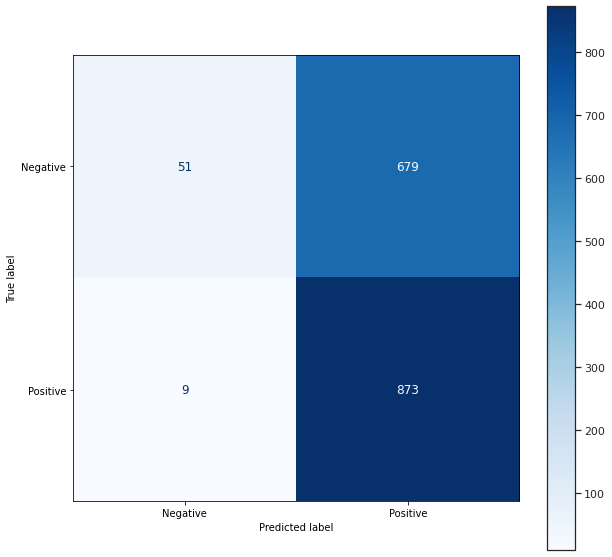

In [ ]:
lr_bw_predict_IMDB = lr.predict(bw_test_IMDB)

#accuracy
lr_bw_score_IMDB = accuracy_score(y_test, lr_bw_predict_IMDB)
print("Bag of Words Score:", lr_bw_score_IMDB)

#classification
lr_bw_class = classification_report(y_test, lr_bw_predict_IMDB, target_names=['Positive','Negative'])
print(lr_bw_class)

labels = ['Negative','Positive']
fig, ax = plt.subplots(figsize = (10,10))
sns.set_theme(style = 'white')
metrics.plot_confusion_matrix(lr,bw_test_IMDB, y_test, cmap = plt.cm.Blues,ax=ax, display_labels=labels)

In [ ]:
fprs_IMDB = []
tprs_IMDB = []
aucs_IMDB = []

yproba = lr_bw_IMDB.predict_proba(bw_test_IMDB)[::,1]
auc = roc_auc_score(y_test, yproba)
fpr, tpr, _ = roc_curve(y_test, yproba)

fprs_IMDB.append(fpr)
tprs_IMDB.append(tpr)
aucs_IMDB.append(auc)

### TF-IDF - IMDB

Word embedding through TF-IDF for Logistic Regression

In [ ]:
tfidf=TfidfVectorizer(min_df=0, max_df=1, use_idf=True, ngram_range=(1,3))

#transformed X training set 
tfidf_train_IMDB=tfidf.fit_transform(X_train)

#transformed X test set 
tfidf_test_IMDB=tfidf.transform(X_test)

Fitting and training the model

In [ ]:
lr_tfidf_IMDB=lr.fit(tfidf_train_IMDB,y_train)

Predicting and checking accuracy

TF-IDF Score: 0.5477667493796526
              precision    recall  f1-score   support

    Positive       0.67      0.00      0.01       730
    Negative       0.55      1.00      0.71       882

    accuracy                           0.55      1612
   macro avg       0.61      0.50      0.36      1612
weighted avg       0.60      0.55      0.39      1612



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


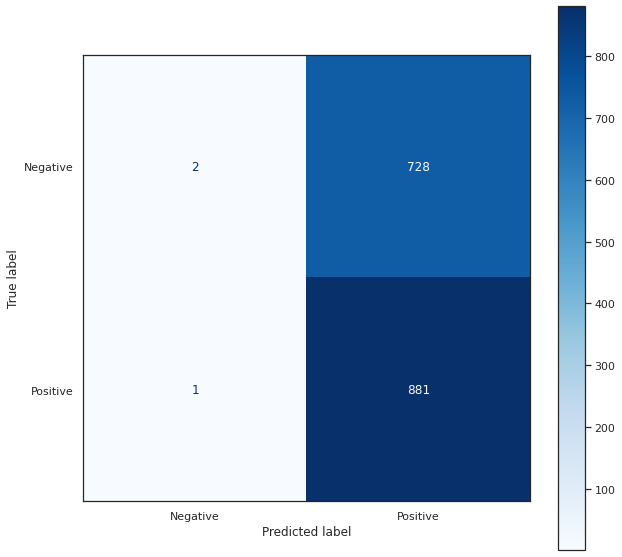

In [ ]:
lr_tfidf_predict_IMDB = lr.predict(tfidf_test_IMDB)

#accuracy
lr_tfidf_score_IMDB = accuracy_score(y_test, lr_tfidf_predict_IMDB)
print("TF-IDF Score:", lr_tfidf_score_IMDB)

#classification
lr_tfidf_class_IMDB = classification_report(y_test, lr_tfidf_predict_IMDB, target_names=['Positive','Negative'])
print(lr_tfidf_class_IMDB)

#confusion matrix
labels = ['Negative','Positive']
fig, ax = plt.subplots(figsize = (10,10))
sns.set_theme(style = 'white')
metrics.plot_confusion_matrix(lr, tfidf_test_IMDB, y_test, cmap = plt.cm.Blues,
                                ax=ax, display_labels=labels)

In [ ]:
yproba = lr_tfidf_IMDB.predict_proba(tfidf_test_IMDB)[::,1]
auc = roc_auc_score(y_test, yproba)
fpr, tpr, _ = roc_curve(y_test, yproba)

fprs_IMDB.append(fpr)
tprs_IMDB.append(tpr)
aucs_IMDB.append(auc)

### Bag of Words - Metacritics

Undersampling to resolve the imbalance

In [ ]:
#Undersampling
Meta_features = tfidf_converter.fit_transform(Metacritics['Review_cleaned']).toarray()

# Split Data of Metacritics
X = Meta_features
y = Metacritics['Emotion']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

under = RandomUnderSampler(sampling_strategy = 0.9, random_state = 42)
X_under, y_under = under.fit_resample(X_train, y_train)
print(Counter(y_under))

Counter({1.0: 278, 0.0: 251})


Word embedding through Bag of Words for Logistic Regression

Fitting and training the model

In [ ]:
lr = LogisticRegression(penalty='l2', max_iter=500, C=1, random_state=42)

lr_bw_Meta = lr.fit(X_under, y_under)

Predicting and checking accuracy

Bag of Words Score: 0.7142857142857143
              precision    recall  f1-score   support

    Positive       0.64      0.45      0.53        67
    Negative       0.74      0.86      0.80       122

    accuracy                           0.71       189
   macro avg       0.69      0.65      0.66       189
weighted avg       0.70      0.71      0.70       189



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


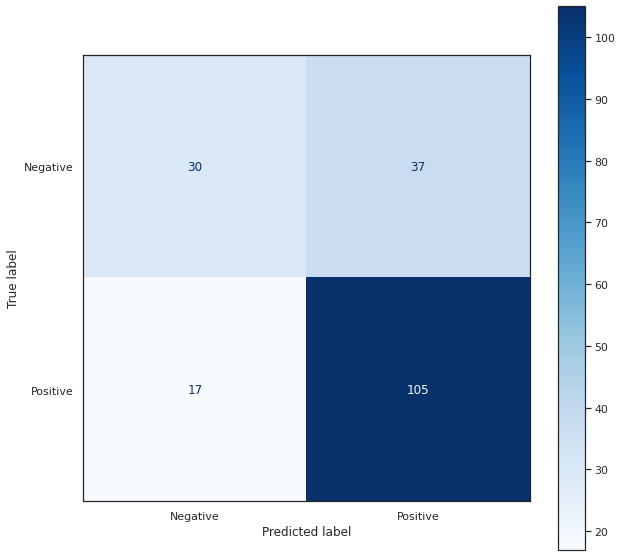

In [ ]:
lr_bw_predict_Meta = lr.predict(X_test)

#accuracy
lr_bw_score_Meta = accuracy_score(y_test, lr_bw_predict_Meta)
print("Bag of Words Score:", lr_bw_score_Meta)

#classification
lr_bw_class_Meta = classification_report(y_test, lr_bw_predict_Meta, target_names=['Positive','Negative'])
print(lr_bw_class_Meta)

#confusion matrix
labels = ['Negative','Positive']
fig, ax = plt.subplots(figsize = (10,10))
sns.set_theme(style = 'white')
metrics.plot_confusion_matrix(lr,X_test, y_test, cmap = plt.cm.Blues,ax=ax, display_labels=labels)

In [ ]:
fprs_Meta = []
tprs_Meta = []
aucs_Meta = []

yproba = lr_bw_Meta.predict_proba(X_test)[::,1]
auc = roc_auc_score(y_test, yproba)
fpr, tpr, _ = roc_curve(y_test, yproba)

fprs_Meta.append(fpr)
tprs_Meta.append(tpr)
aucs_Meta.append(auc)

### TF-IDF Metacritics

Word embedding through TF-IDF for Logistic Regression

In [ ]:
Meta_features = tfidf_converter.fit_transform(Metacritics['Review_cleaned']).toarray()

# Split Data of Metacritics
Meta_X = Meta_features
Meta_Y = Metacritics[['Emotion']]

# Split into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(Meta_X, Meta_Y, test_size=0.2, random_state=0)

under = RandomUnderSampler(sampling_strategy = 0.9, random_state = 42)
X_under, y_under = under.fit_resample(X_train, y_train)
print(Counter(y_under))

Counter({'Emotion': 1})


Fitting and training the model

In [ ]:
lr_tfidf_meta = lr.fit(X_under, y_under)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Predicting and checking accuracy

TF-IDF Score: 0.6455026455026455
              precision    recall  f1-score   support

    Positive       0.55      0.39      0.46        72
    Negative       0.68      0.80      0.74       117

    accuracy                           0.65       189
   macro avg       0.62      0.60      0.60       189
weighted avg       0.63      0.65      0.63       189



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


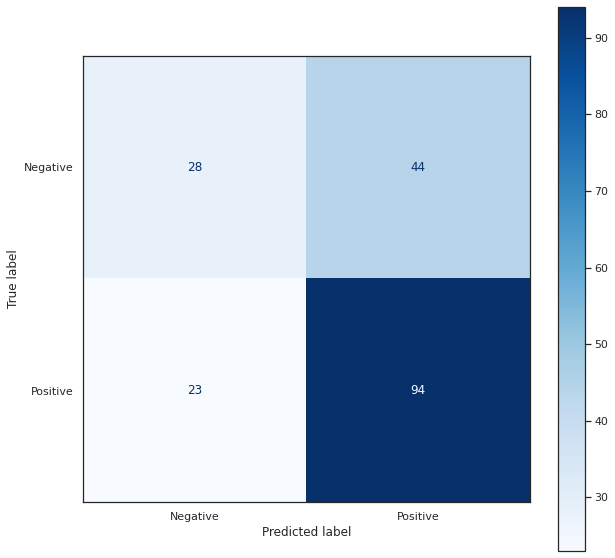

In [ ]:
lr_tfidf_predict_Meta = lr.predict(X_test)

#accuracy
lr_tfidf_score_Meta = accuracy_score(y_test, lr_tfidf_predict_Meta)
print("TF-IDF Score:", lr_tfidf_score_Meta)

#classification
lr_tfidf_class_Meta = classification_report(y_test, lr_tfidf_predict_Meta, target_names=['Positive','Negative'])
print(lr_tfidf_class_Meta)

#confusion matrix
labels = ['Negative','Positive']
fig, ax = plt.subplots(figsize = (10,10))
sns.set_theme(style = 'white')
metrics.plot_confusion_matrix(lr,X_test, y_test, cmap = plt.cm.Blues,ax=ax, display_labels=labels)

In [ ]:
yproba = lr_tfidf_meta.predict_proba(X_test)[::,1]
auc = roc_auc_score(y_test, yproba)
fpr, tpr, _ = roc_curve(y_test, yproba)

fprs_Meta.append(fpr)
tprs_Meta.append(tpr)
aucs_Meta.append(auc)

## 2. Random Forest

Import Random Forest Model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

Define Algorithm 

In [ ]:
tfidf_converter = TfidfVectorizer(max_features = 2000)

def rf(X_train, y_train, X_test, y_test):
    # Fit Model with train data
    text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
    text_classifier.fit(X_train, y_train)

    # Make predictions for test data
    predictions = text_classifier.predict(X_test)

    # evaluate predictions
    print("Accuracy:", metrics.accuracy_score(y_test, predictions))

    yproba = text_classifier.predict_proba(X_test)[::,1]
    auc = roc_auc_score(y_test, yproba)
    print("AUC", auc)

    print(classification_report(y_test,predictions))

    labels = ['Negative','Positive']
    fig, ax = plt.subplots(figsize = (10,10))
    sns.set_theme(style = 'white')
    metrics.plot_confusion_matrix(text_classifier,X_test, y_test, cmap = plt.cm.Blues,
                                ax=ax, display_labels=labels)
    
    return text_classifier

### Random Forest - IMDB

Distribution of IMDB reviews per sentiment

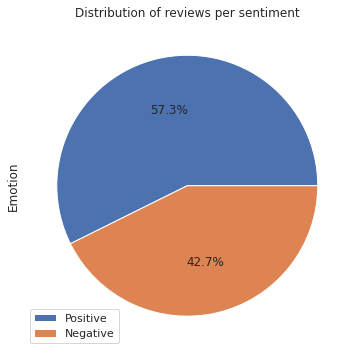

In [ ]:
IMDB['Emotion'].value_counts().plot.pie(figsize=(6,6),title="Distribution of reviews per sentiment",labels=['',''],autopct='%1.1f%%')
labels=["Positive","Negative"]
plt.legend(labels,loc=3)
plt.gca().set_aspect('equal')

Split the 80% data as training data, 20% as test data.

In [ ]:
IMDB_features = tfidf_converter.fit_transform(IMDB['Comment_cleaned']).toarray()

# Split Data of IMDB
IMDB_X = IMDB_features
IMDB_Y = IMDB[['Emotion']]

# Split into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(IMDB_X, IMDB_Y, test_size=0.2, random_state=0)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(6448, 2000) (6448, 1)
(1612, 2000) (1612, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Accuracy: 0.716501240694789
AUC 0.833805521796854
              precision    recall  f1-score   support

         0.0       0.80      0.48      0.60       713
         1.0       0.69      0.91      0.78       899

    accuracy                           0.72      1612
   macro avg       0.74      0.69      0.69      1612
weighted avg       0.74      0.72      0.70      1612



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


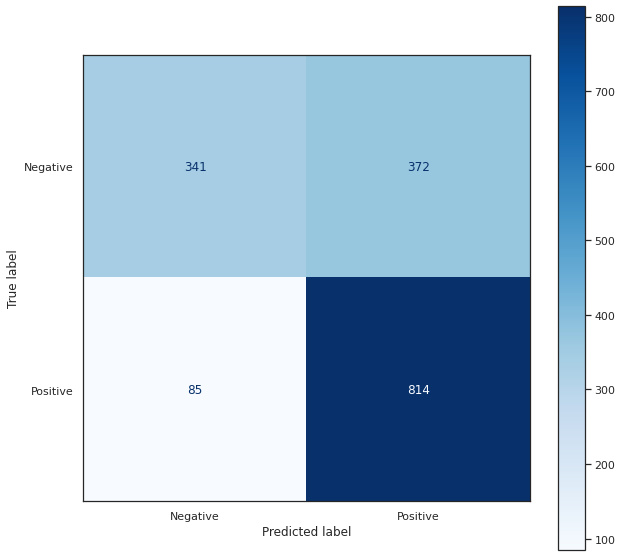

In [ ]:
RF_IMDB = rf(X_train, y_train, X_test, y_test)

In [ ]:
yproba = RF_IMDB.predict_proba(X_test)[::,1]
auc = roc_auc_score(y_test, yproba)
fpr, tpr, _ = roc_curve(y_test,  yproba)

fprs_IMDB.append(fpr)
tprs_IMDB.append(tpr)
aucs_IMDB.append(auc)

### Random Forest - Metacritics

Distribution of Metacritics reviews per sentiment

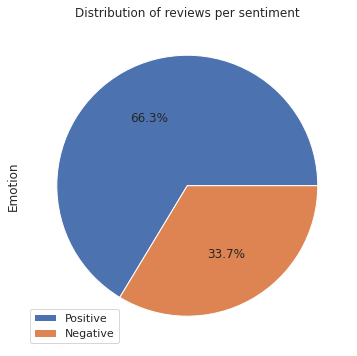

In [ ]:
Metacritics['Emotion'].value_counts().plot.pie(figsize=(6,6),title="Distribution of reviews per sentiment",labels=['',''],autopct='%1.1f%%')
labels=["Positive","Negative"]
plt.legend(labels,loc=3)
plt.gca().set_aspect('equal')

Split the 80% data as training data, 20% as test data.

In [ ]:
Meta_features = tfidf_converter.fit_transform(Metacritics['Review_cleaned']).toarray()

# Split Data of Metacritics
Meta_X = Meta_features
Meta_Y = Metacritics[['Emotion']]

# Split into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(Meta_X, Meta_Y, test_size=0.2, random_state=0)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(756, 2000) (756, 1)
(189, 2000) (189, 1)


Counter({'Emotion': 1})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Accuracy: 0.6243386243386243
AUC 0.6173433048433048
              precision    recall  f1-score   support

         0.0       0.51      0.31      0.38        72
         1.0       0.66      0.82      0.73       117

    accuracy                           0.62       189
   macro avg       0.58      0.56      0.56       189
weighted avg       0.60      0.62      0.60       189



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


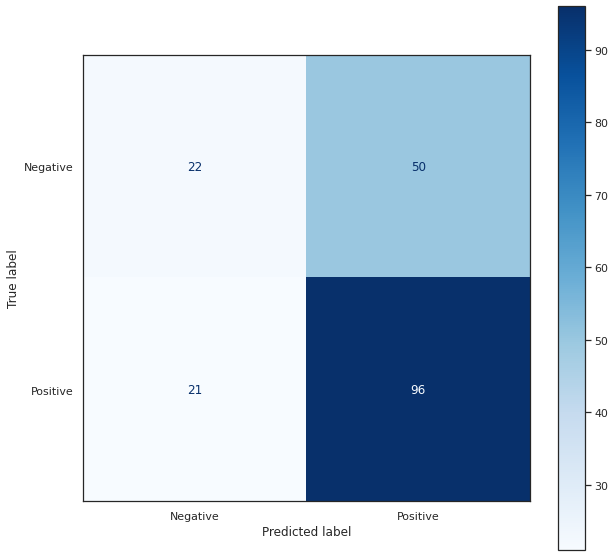

In [ ]:
under = RandomUnderSampler(sampling_strategy = 0.9, random_state = 42)
X_under, y_under = under.fit_resample(X_train, y_train)
print(Counter(y_under))

RF_Meta = rf(X_under, y_under, X_test, y_test)

In [ ]:
yproba = RF_Meta.predict_proba(X_test)[::,1]
auc = roc_auc_score(y_test, yproba)
fpr, tpr, _ = roc_curve(y_test,  yproba)

fprs_Meta.append(fpr)
tprs_Meta.append(tpr)
aucs_Meta.append(auc)

## 3. LightGBM

IMDB dataset is approximately balanced.

MetaCritics dataset's 0:1 ≈ 1:2, so we need to fix the imbalance before fit model.

In [ ]:
print(f"IMDb sentiment distribution:\n{IMDB['Emotion'].value_counts()}\n")
print(f"MetaCritics sentiment distribution:\n{Metacritics['Emotion'].value_counts()}")

IMDb sentiment distribution:
1.0    4621
0.0    3439
Name: Emotion, dtype: int64

MetaCritics sentiment distribution:
1.0    627
0.0    318
Name: Emotion, dtype: int64


**LightGBM-IMDB**

Split the 80% data as training data, 20% as test data.

In [ ]:
def lgbm(X_train, y_train, X_test, y_test):
  gbm = lgb.LGBMClassifier(boosting_type = 'gbdt',
                        objective = 'binary',
                        metric = 'auc',
                        random_state = 1204)
  gbm.fit(X_train, y_train)

  y_pred = gbm.predict(X_test)

  print("Accuracy", metrics.accuracy_score(y_test, y_pred))
  yproba = gbm.predict_proba(X_test)[::,1]
  auc = roc_auc_score(y_test, yproba)
  print("AUC", auc)

  labels = ['Negative','Positive']
  fig, ax = plt.subplots(figsize = (10,10))
  sns.set_theme(style = 'white')
  metrics.plot_confusion_matrix(gbm,X_test, y_test, cmap = plt.cm.Blues,
                                ax=ax, display_labels=labels)
  print(metrics.classification_report(y_test,y_pred))
  return gbm

Accuracy 0.7444168734491315
AUC 0.8402960270866338
              precision    recall  f1-score   support

         0.0       0.82      0.56      0.66       730
         1.0       0.71      0.90      0.79       882

    accuracy                           0.74      1612
   macro avg       0.77      0.73      0.73      1612
weighted avg       0.76      0.74      0.73      1612



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


LGBMClassifier(metric='auc', objective='binary', random_state=1204)

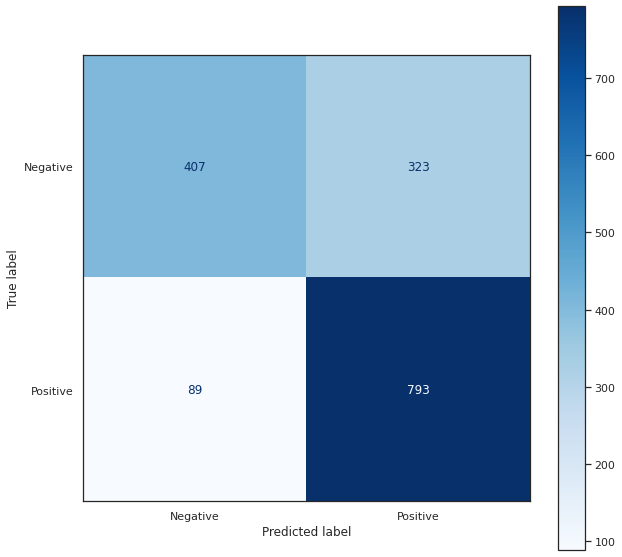

In [ ]:
X = features_imdb
y = IMDB['Emotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

LightGBM_IMDB = lgbm(X_train, y_train, X_test, y_test)
LightGBM_IMDB

Store the True Positive Rate, False Positive Rate, and AUC score as the preparation of model comparison.

In [ ]:
yproba = LightGBM_IMDB.predict_proba(X_test)[::,1]
auc = roc_auc_score(y_test, yproba)
fpr, tpr, _ = roc_curve(y_test,  yproba)

fprs_IMDB.append(fpr)
tprs_IMDB.append(tpr)
aucs_IMDB.append(auc)

**LightGBM Original Model-MetaCritics**

Split the 80% data as training data, 20% as test data.

Accuracy 0.6613756613756614
AUC 0.6219721066797163
              precision    recall  f1-score   support

         0.0       0.55      0.24      0.33        67
         1.0       0.68      0.89      0.77       122

    accuracy                           0.66       189
   macro avg       0.62      0.57      0.55       189
weighted avg       0.64      0.66      0.62       189



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


LGBMClassifier(metric='auc', objective='binary', random_state=1204)

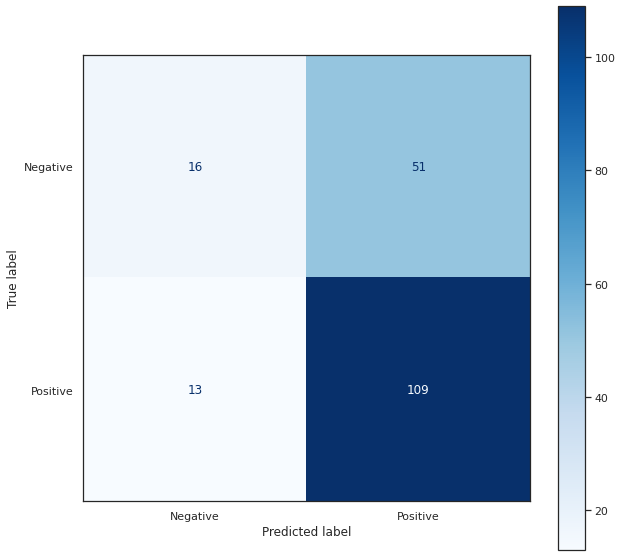

In [ ]:
X = features_meta
y = Metacritics['Emotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

LightGBM_Meta_Original = lgbm(X_train, y_train, X_test, y_test)
LightGBM_Meta_Original

In [ ]:
yproba = LightGBM_Meta_Original.predict_proba(X_test)[::,1]
auc = roc_auc_score(y_test, yproba)
fpr, tpr, _ = roc_curve(y_test,  yproba)

fprs_Meta.append(fpr)
tprs_Meta.append(tpr)
aucs_Meta.append(auc)

**LightGBM Undersampled Model-MetaCritics**

To fix the imbalance, we use the Undersampling method. After a lot of trials testing sampling_strategy from [0,1,0.1], 0.9 works the best.

After fixing the imbalance, accuracy and AUC almost remain the same, but the F1 score of minority class improves from 0.25 to 0.37.

Counter({1.0: 278, 0.0: 251})
Accuracy 0.5661375661375662
AUC 0.5628211402006361
              precision    recall  f1-score   support

         0.0       0.40      0.43      0.41        67
         1.0       0.67      0.64      0.66       122

    accuracy                           0.57       189
   macro avg       0.53      0.54      0.53       189
weighted avg       0.57      0.57      0.57       189



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


LGBMClassifier(metric='auc', objective='binary', random_state=1204)

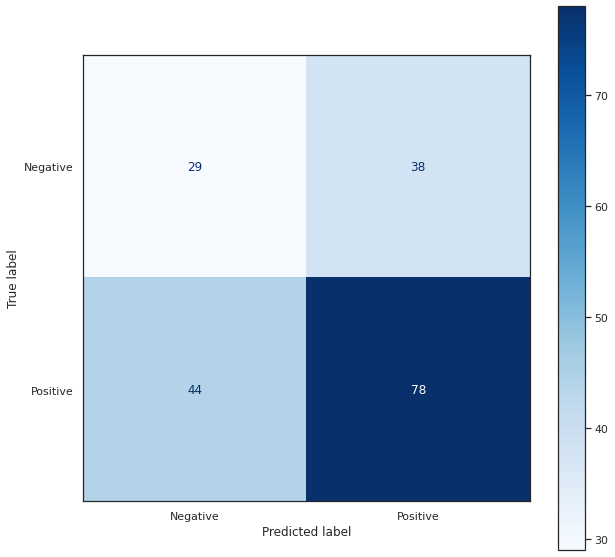

In [ ]:
under = RandomUnderSampler(sampling_strategy = 0.9, random_state = 42)
X_under, y_under = under.fit_resample(X_train, y_train)
print(Counter(y_under))

LightGBM_Meta_UnderSampled = lgbm(X_under, y_under, X_test, y_test)
LightGBM_Meta_UnderSampled

In [ ]:
yproba = LightGBM_Meta_UnderSampled.predict_proba(X_test)[::,1]
auc = roc_auc_score(y_test, yproba)
fpr, tpr, _ = roc_curve(y_test,  yproba)

fprs_Meta.append(fpr)
tprs_Meta.append(tpr)
aucs_Meta.append(auc)

## 4. Recurrent Neural Network-Long Short-Term Memory network (RNN-LSTM)

**Word Embedding**

Because we are going to use the deep learning model instead of classic machine learning model, we won't be using the TF-IDF to vectorize the text, what we do is turning text into low-dimensional floating-point vectors.

To avoid overfitting, a dropout layer with 20% dropout is inserted between the embedding layer and the output layer.

In [ ]:
IMDB['Comment_cleaned'] = np.array(IMDB['Comment_cleaned'])
Metacritics['Review_cleaned'] = np.array(Metacritics['Review_cleaned'])

max_words = 5000
max_len = 200

# IMDB
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(IMDB['Comment_cleaned'])
sequences = tokenizer.texts_to_sequences(IMDB['Comment_cleaned'])
IMDB_review = pad_sequences(sequences, maxlen=max_len)

# MetaCritics
tokenizer.fit_on_texts(Metacritics['Review_cleaned'])
sequences = tokenizer.texts_to_sequences(Metacritics['Review_cleaned'])
Meta_review = pad_sequences(sequences, maxlen=max_len)

**LSTM Model-IMDB**

In [ ]:
def nn(X_train, X_test, y_train, y_test):
  rnn = Sequential()
  rnn.add(layers.Embedding(max_words, 20))
  rnn.add(layers.LSTM(15,dropout=0.2))
  rnn.add(Flatten())
  rnn.add(layers.Dense(1,activation='sigmoid'))

  rnn.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy',tf.keras.metrics.AUC()])
  #Implementing model checkpoins to save the best metric and do not lose it on training.
  checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=0,
                                save_best_only=True, mode='auto', period=1,save_weights_only=False)
  rnn.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint1],verbose=0)

  loss, acc, auc_score = rnn.evaluate(X_test, y_test, verbose=0)
  print(f'Accuracy:{acc}')
  print(f'AUC:{auc_score}')

  y_pred = rnn.predict(X_test)
  cm = metrics.confusion_matrix(y_test, np.rint(y_pred))
  labels = ['Negative','Positive']
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  fig, ax = plt.subplots(figsize=(10,10))
  disp.plot(cmap=plt.cm.Blues, ax=ax)
  return rnn, auc_score

Split the 80% data as training data, 20% as test data.

Accuracy:0.7227047085762024
AUC:0.7810897827148438


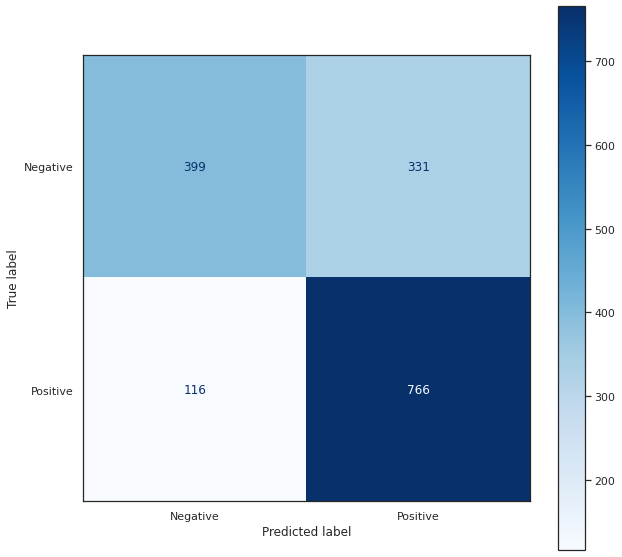

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(IMDB_review,IMDB['Emotion'], test_size = 0.2, random_state=42)

LSTM_IMDB, auc_m = nn(X_train, X_test, y_train, y_test)
LSTM_IMDB

In [ ]:
y_pred_keras = LSTM_IMDB.predict(X_test).ravel()
fpr, tpr, _ = roc_curve(y_test, y_pred_keras)

fprs_IMDB.append(fpr)
tprs_IMDB.append(tpr)
aucs_IMDB.append(auc_m)

**LSTM Model-MetaCritics**

Split the 80% data as training data, 20% as test data.

Accuracy:0.6984127163887024
AUC:0.70106440782547


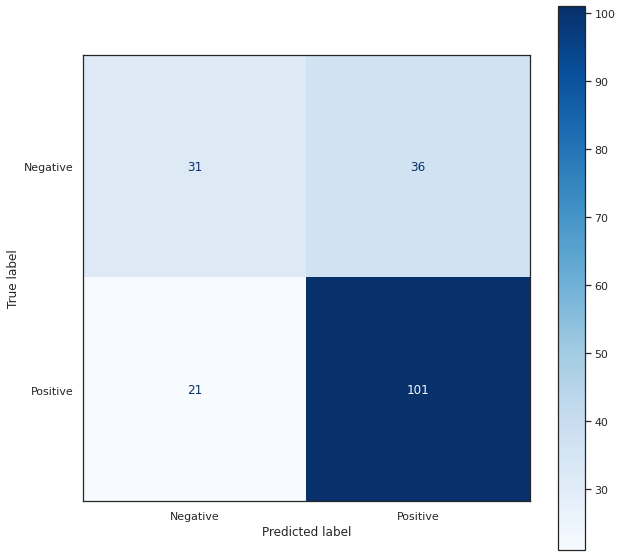

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Meta_review,Metacritics['Emotion'],
                                                    test_size = 0.2, random_state=42)

LSTM_Meta_Original, auc_m = nn(X_train, X_test, y_train, y_test)
LSTM_Meta_Original

In [ ]:
y_pred_keras = LSTM_Meta_Original.predict(X_test).ravel()
fpr, tpr, _ = roc_curve(y_test, y_pred_keras)

fprs_Meta.append(fpr)
tprs_Meta.append(tpr)
aucs_Meta.append(auc_m)

**LSTM Undersampled Model-MetaCritics**

Counter({1.0: 278, 0.0: 251})
Accuracy:0.682539701461792
AUC:0.7307316064834595


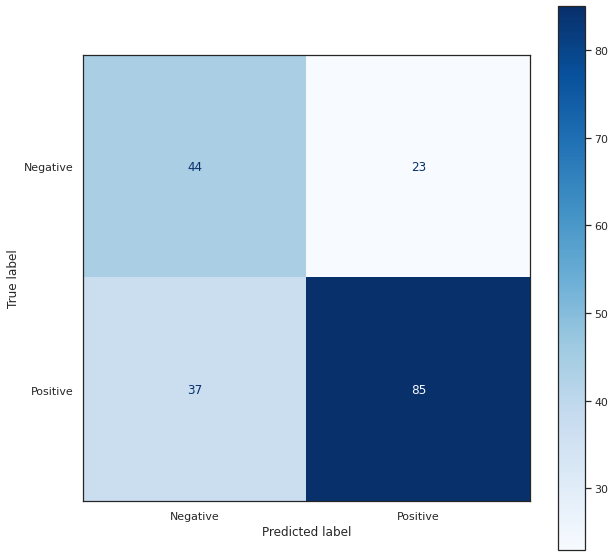

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Meta_review,Metacritics['Emotion'],
                                                    test_size = 0.2, random_state=42)

under = RandomUnderSampler(sampling_strategy = 0.9, random_state = 42)
X_under, y_under = under.fit_resample(X_train, y_train)
print(Counter(y_under))

LSTM_Meta_UnderSampled, auc_m = nn(X_under, X_test, y_under, y_test)
LSTM_Meta_UnderSampled

In [ ]:
y_pred_keras = LSTM_Meta_UnderSampled.predict(X_test).ravel()
fpr, tpr, _ = roc_curve(y_test, y_pred_keras)

fprs_Meta.append(fpr)
tprs_Meta.append(tpr)
aucs_Meta.append(auc_m)

## 5. Model Comparison

In [ ]:
Models_IMDB = ['BW_IMDB', 'TFIDF_IMDB','RF_IMDB','LightGBM_IMDB','LSTM_IMDB']
Models_Meta = ['BW_Meta', 'TFIDF_Meta','RF_Meta','LightGBM_Meta_Original', 'LightGBM_Meta_UnderSampled',
               'LSTM_Meta_Original', 'LSTM_Meta_UnderSampled']

ROC_table_IMDB = pd.DataFrame({'Models_IMDB':Models_IMDB, 'fpr':fprs_IMDB,
                               'tpr':tprs_IMDB, 'auc':aucs_IMDB})
ROC_table_Meta = pd.DataFrame({'Models_Meta':Models_Meta, 'fpr':fprs_Meta,
                               'tpr':tprs_Meta, 'auc':aucs_Meta})

ROC_table_IMDB.set_index('Models_IMDB', inplace=True)
ROC_table_Meta.set_index('Models_Meta', inplace=True)

In [ ]:
def RocCurve(table):
  fig = plt.figure(figsize=(10,10))

  for i in table.index:
      plt.plot(table.loc[i]['fpr'], 
              table.loc[i]['tpr'], 
              label="{}, AUC={:.3f}".format(i, table.loc[i]['auc']))
      
  plt.plot([0,1], [0,1], color='orange', linestyle='--')

  plt.xticks(np.arange(0.0, 1.1, step=0.1))
  plt.xlabel("Flase Positive Rate", fontsize=15)

  plt.yticks(np.arange(0.0, 1.1, step=0.1))
  plt.ylabel("True Positive Rate", fontsize=15)

  plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
  plt.legend(prop={'size':13}, loc='lower right')

  plt.show()

**Models for IMDB Reviews Comparison**

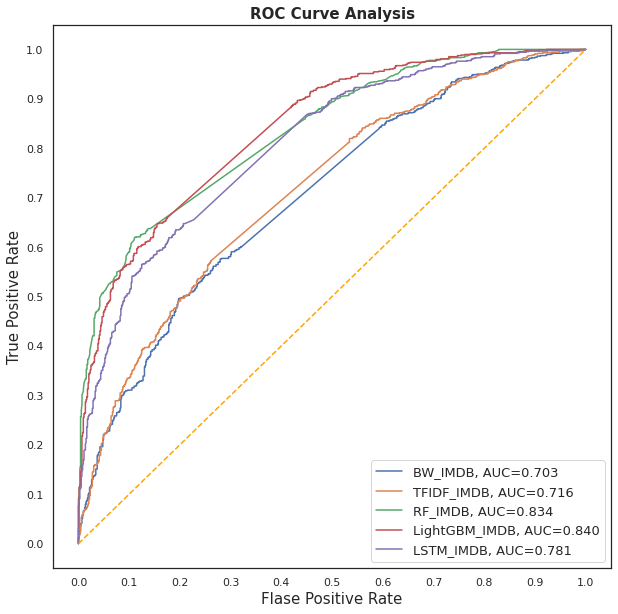

In [ ]:
RocCurve(ROC_table_IMDB)

**Models for MetaCritics Reviews Comparison**

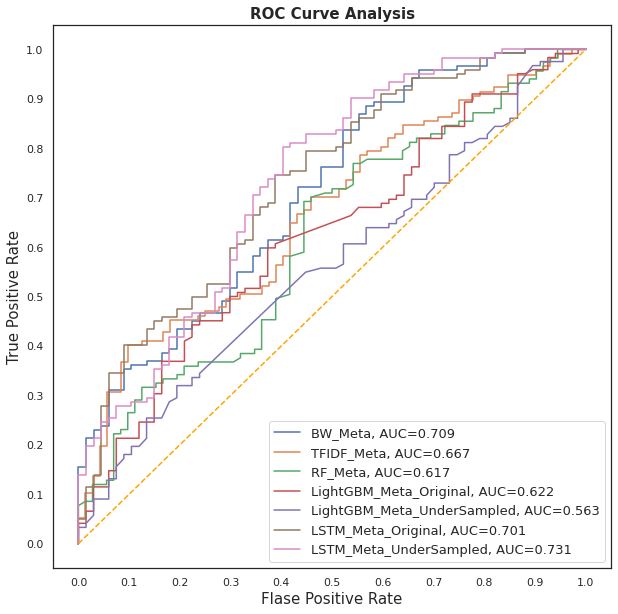

In [ ]:
RocCurve(ROC_table_Meta)